### Bu kaynak kodları GPT modelini anlattığım iki yazımın kaynak kodlarıdır
yazılarıma buradan erişebilirsiniz
* [GPT Yapısı: Kod, Anlatım ve Görsel Analiz](https://medium.com/%40canbing0l/ad%C4%B1m-ad%C4%B1m-gpt-modeli-kodlamas%C4%B1-4afde7df1d6b)
* [GPT Eğitim Süreci, Veri Kaynaklar ve Teknikler](https://medium.com/@canbing0l/gpt-e%C4%9Fitim-s%C3%BCreci-veri-kaynaklar-ve-teknikler-7915b998cb4d)


In [1]:
import torch
import torch.nn as nn
import tiktoken
from torch.utils.data import Dataset, DataLoader
tokenizer = tiktoken.get_encoding("gpt2")

In [2]:
ModelConfig = {
 "vocab_size": 50257,  # Kelime dağarcığı boyutu
 "context_length": 256,  # Bağlam uzunluğu
 "emb_dim": 384,  # Gömülü (embedding) boyutu
 "n_heads": 12,  # Dikkat başlıklarının (attention heads) sayısı
 "n_layers": 12,  # Katman sayısı
 "drop_rate": 0.1,  # Dropout oranı
 "qkv_bias": False  # Sorgu-Anahtar-Değer (Query-Key-Value) bias'ı
}

In [3]:
class LayerNorm(nn.Module):

    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5  # Küçük bir sabit, sayısal kararlılık sağlamak için eklenir (0'a bölme hatalarını önler)
        self.scale = nn.Parameter(torch.ones(emb_dim))  # Öğrenilebilir bir parametre: her katman için ölçekleme (scaling)
        self.shift = nn.Parameter(torch.zeros(emb_dim))  # Öğrenilebilir bir parametre: her katman için kaydırma (shifting)

    def forward(self, x):
        # Giriş tensörünün son boyutunun ortalamasını hesapla (x'in her bir örneği için)
        mean = x.mean(dim=-1, keepdim=True)

        # Giriş tensörünün son boyutunun varyansını hesapla (x'in her bir örneği için)
        var = x.var(dim=-1, keepdim=True, unbiased=False)

        # Normalizasyon işlemi: (x - mean) / sqrt(var + eps)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)

        # Sonuçları ölçekleme (scale) ve kaydırma (shift) parametreleriyle düzenle
        return self.scale * norm_x + self.shift

In [4]:
class GELU(nn.Module):
     def __init__(self):
         super().__init__()
     def forward(self, x):
         return 0.5 * x * (1 + torch.tanh(
         torch.sqrt(torch.tensor(2.0 / torch.pi)) *
         (x + 0.044715 * torch.pow(x, 3))
         ))

class MLP(nn.Module):

    def __init__(self, config:ModelConfig):
        super().__init__()
        self.emb_dim = config["emb_dim"]
        self.vocab_size = config["vocab_size"]
        self.context_len = config["context_length"]
        
        self.layers = nn.Sequential(
            nn.Linear(self.emb_dim, 4 * self.emb_dim),
            GELU(),
            nn.Linear(self.emb_dim * 4, self.emb_dim)
        )

    def forward(self,x):
        return self.layers(x)

In [5]:
class MultiHeadAttention(nn.Module):
    # Yapıcı fonksiyon: Modelin başlangıç parametrelerini tanımlar.
    def __init__(self, config):
        super().__init__()
        # Modelin iç parametreleri
        self.emb_dim = config["emb_dim"]  # Gömme (embedding) boyutu
        self.qkv_bias = config["qkv_bias"]  # Sorgu, anahtar ve değer için bias kullanılıp kullanılmayacağı
        self.n_heads = config["n_heads"]  # Başlık sayısı (multi-head attention)
        self.context_length = config["context_length"]  # Bağlam uzunluğu (örneğin, dil modeli için cümledeki kelime sayısı)
        
        # Her bir başlık için gömme boyutunu hesapla
        self.head_dim = self.emb_dim // self.n_heads
        # emb_dim'in n_heads'e bölünebilir olup olmadığını kontrol et
        assert (self.emb_dim % self.n_heads == 0), \
             "emb_dim must be divisible by num_heads"
    
        # Sorgu (Q), anahtar (K) ve değer (V) için lineer dönüşümler
        self.Wq = nn.Linear(self.emb_dim, self.emb_dim, bias=self.qkv_bias)
        self.Wk = nn.Linear(self.emb_dim, self.emb_dim, bias=self.qkv_bias)
        self.Wv = nn.Linear(self.emb_dim, self.emb_dim, bias=self.qkv_bias)
        # Sonuç projeksiyonu: tüm başlıkların birleşiminden sonra son çıkışı hesaplayacak
        self.out_proj = nn.Linear(self.emb_dim, self.emb_dim)
        
        # Mask oluşturuluyor: modelin sadece geçerli token'ları dikkate almasını sağlıyor
        # Bu mask, geleceği görmesini engellemek için kullanılır (Özellikle dil modelleri için)
        self.register_buffer(
         "mask",
        torch.triu(torch.ones(self.context_length, self.context_length),
         diagonal=1
                    ))
        
    def forward(self, x):
        # Giriş verisi şekli: (batch_size, seq_len, emb_dim)
        batch_size, seq_len, emb_dim = x.shape

        # Sorgu, anahtar ve değer hesaplamaları: her biri için lineer projeksiyon
        q = self.Wq(x)  # Sorgular (Query)
        k = self.Wk(x)  # Anahtarlar (Key)
        v = self.Wv(x)  # Değerler (Value)

        # Başlıkları ayırmak için her birini yeniden şekillendiriyoruz
        k = k.view(batch_size, seq_len, self.n_heads, self.head_dim)
        v = v.view(batch_size, seq_len, self.n_heads, self.head_dim)
        q = q.view(batch_size, seq_len, self.n_heads, self.head_dim)
        
        # Diziyi yeniden şekillendiriyoruz (k, q, v sırasıyla): (b, seq_len, n_heads, head_dim) -> (b, n_heads, seq_len, head_dim)
        k = k.transpose(1, 2)
        q = q.transpose(1, 2)
        v = v.transpose(1, 2)
        
        # Dikkat skorlarını hesapla: Sorgu ve Anahtarların çarpımı
        attn_scores = q @ k.transpose(2, 3)  # (b, n_heads, seq_len, seq_len)

        # Mask uygulaması: modelin sadece geçerli token'ları kullanmasına izin verir
        mask_bool = self.mask.bool()[:seq_len, :seq_len]  # Mask'ın uygun kısmını al
        attn_scores.masked_fill_(mask_bool, -torch.inf)  # Geleceği görmesini engeller (sonsuz küçük bir değere ayarlama)

        # Softmax uygulaması: Dikkat skorlarını normalleştir
        attn_weights = torch.softmax(
                attn_scores / k.shape[-1]**0.5, dim=-1
                                        )  # Skorları normalize et, d_k (head_dim) ile ölçeklendir
        
        # Dikkat ağırlıkları ile değerleri çarp
        context_vec = (attn_weights @ v).transpose(1, 2)  # (b, n_heads, seq_len, head_dim) -> (b, seq_len, n_heads, head_dim)
        
        # Başlıkları birleştir (d_out = n_heads * head_dim)
        context_vec = context_vec.contiguous().view(
             batch_size, seq_len, self.emb_dim
                                                    )
        
        # Son projeksiyonu uygula: Başlıkları birleştirdikten sonra çıkışı hesapla
        context_vec = self.out_proj(context_vec)  # Sonuçları projekte et

        return context_vec

In [6]:
class TransformerBlock(nn.Module):
    # Yapıcı fonksiyon: Transformer bloğunu oluşturur
    def __init__(self, config):
        super().__init__()
        # MultiHeadAttention modülünü başlatıyoruz
        self.att = MultiHeadAttention(config)
        # Feedforward (MLP) modülünü başlatıyoruz
        self.ff = MLP(config)
        # Layer normalization katmanlarını başlatıyoruz
        self.norm1 = LayerNorm(config["emb_dim"])  # İlk layer norm (attention öncesi)
        self.norm2 = LayerNorm(config["emb_dim"])  # İkinci layer norm (feedforward öncesi)
        
    def forward(self, x):
        # Giriş verisinin kısa yolunu kaydediyoruz (residual connection)
        shortcut = x
        
        # İlk normalization işlemi: Layer norm uygulandıktan sonra self-attention
        x = self.norm1(x)  # İlk normalizasyon
        x = self.att(x)  # Multi-head attention uygulaması
        
        # Residual connection: dikkat (self-attention) çıktısı kısa yol ile toplanır
        x = x + shortcut  # Kısa yol bağlantısı ekleniyor
        
        # Yeni bir kısa yol oluşturuyoruz (feedforward için)
        shortcut = x
        
        # İkinci normalization işlemi: Feedforward ağına (MLP) geçiş öncesi
        x = self.norm2(x)  # İkinci normalizasyon
        x = self.ff(x)  # Feedforward (MLP) işlemi
        
        # Residual connection: feedforward çıktısı ile kısa yol bağlantısını topluyoruz
        x = x + shortcut  # Kısa yol bağlantısı ekleniyor
        
        return x 

In [7]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [8]:
class GPTModel(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        # Token embedding tablosu: her token ID'si için d_model boyutunda vektörler.
        # Vocab boyutu (cfg["vocab_size"]) ve her token'in embedding boyutu (cfg["emb_dim"]) parametreleriyle oluşturuluyor.
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])

        # Positional embedding tablosu: her token'in cümledeki pozisyonunu temsil eden embedding.
        # Cümledeki en uzun token sayısı (cfg["context_length"]) ve embedding boyutu (cfg["emb_dim"]) parametreleriyle oluşturuluyor.
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])

        # Transformer bloklarının ardışık dizisi (Sequential): 
        # Burada modelin içinde cfg["n_layers"] kadar TransformerBlock bulunuyor. 
        # Her TransformerBlock, attention ve feedforward katmanlarını içeriyor.
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        # Son layer normalization katmanı: Modelin çıktısı üzerinde normalizasyon uygulanarak, öğrenmenin stabilleşmesi sağlanır.
        self.final_norm = LayerNorm(cfg["emb_dim"])

        # Çıktı başlığı (output head): Sonuçları vocab boyutuna (cfg["vocab_size"]) eşleştiren bir lineer katman.
        # Bu katman, modelin final tahminlerini yapabilmesi için gereklidir.
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        # Girişin boyutlarını alıyoruz: (batch_size, seq_len)
        batch_size, seq_len = in_idx.shape

        # Token embeddingler: Her token ID'si için embeddingler alınıyor.
        tok_embeds = self.tok_emb(in_idx)

        # Positional embeddingler: Cümledeki her token'in pozisyonuna karşılık gelen embeddingler alınıyor.
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        # Token ve positional embeddingleri topluyoruz. Bu şekilde hem token'in anlamı hem de pozisyonu dikkate alınır.
        x = tok_embeds + pos_embeds

        # Transformer bloklarında geçiyor: Modelin temel özelliklerini öğrenebilmesi için.
        x = self.trf_blocks(x)

        # Son layer normalization: Çıktıları normalize ediyoruz.
        x = self.final_norm(x)

        # Çıktıyı lineer katmandan geçiriyoruz. Bu, modelin vocab_size kadar olasılık dağılımı oluşturmasını sağlar.
        logits = self.out_head(x)

        # Sonuç olarak, logits (tahminler) döndürülüyor.
        return logits


In [9]:
model = GPTModel(ModelConfig)
def generate_text_simple(model, idx,
            max_new_tokens, context_size):
    for i in range(max_new_tokens):
        idx_cound = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cound)

        logits = logits[:,-1,:]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx,idx_next), dim=1)

    return idx

start_context = "Merhaba ben"
encoded = tokenizer.encode(start_context)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
model.eval()
out = generate_text_simple(
 model=model,
 idx=encoded_tensor,
 max_new_tokens=6,
 context_size=ModelConfig["context_length"]
)

decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Merhaba ben Lumia251Collectionpopulation inline illegally


In [10]:
file_path = "small_data.txt"
with open(file_path, "r", encoding="utf-8") as f:
    text_data = f.read()

In [11]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 1000000
Tokens: 492914


In [12]:
train_ratio = .9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [13]:
class GPTDataset(Dataset):

    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)
       
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1: i+1+max_length]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [14]:
def create_dataloader(text, batch_size, max_length,
                     stride, shuffle, drop_last, num_workers):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDataset(text, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset, 
        batch_size = batch_size,
        shuffle = shuffle,
        drop_last = drop_last,
        num_workers = num_workers
    )
    return dataloader

In [15]:
train_loader = create_dataloader(
    train_data,
    batch_size=2,
    max_length=ModelConfig["context_length"],
    stride=ModelConfig["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader(
    val_data,
    batch_size=2,
    max_length=ModelConfig["context_length"],
    stride=ModelConfig["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [16]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
    logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

In [17]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
            input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [18]:
# Eğer sistemde CUDA destekli bir GPU varsa "cuda" kullan, yoksa "cpu" kullan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # modeli uygun olan cihaza taşı
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
    
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.993324863442648
Validation loss: 10.991936892271042


In [19]:
def train_model_simple(model, train_loader, val_loader,
                        optimizer, device, num_epochs,
                        eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}"
                )
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen

In [20]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
         )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

In [21]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [22]:
torch.manual_seed(123)
model = GPTModel(ModelConfig)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004, weight_decay=0.1
)
num_epochs = 5
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=100, eval_iter=5,
    start_context="Ben bir dil modeliyim", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 10.439, Val loss 10.283
Ep 1 (Step 000100): Train loss 5.240, Val loss 5.243
Ep 1 (Step 000200): Train loss 4.980, Val loss 4.642
Ep 1 (Step 000300): Train loss 4.526, Val loss 4.457
Ep 1 (Step 000400): Train loss 4.295, Val loss 4.238
Ep 1 (Step 000500): Train loss 3.957, Val loss 4.116
Ep 1 (Step 000600): Train loss 3.872, Val loss 4.082
Ep 1 (Step 000700): Train loss 3.703, Val loss 4.018
Ep 1 (Step 000800): Train loss 4.118, Val loss 3.912
Ben bir dil modeliyimizininininininininininininininininininininininininininininininininininininininininininininininininin
Ep 2 (Step 000900): Train loss 3.663, Val loss 3.914
Ep 2 (Step 001000): Train loss 3.713, Val loss 3.857
Ep 2 (Step 001100): Train loss 3.680, Val loss 3.817
Ep 2 (Step 001200): Train loss 3.511, Val loss 3.774
Ep 2 (Step 001300): Train loss 3.470, Val loss 3.779
Ep 2 (Step 001400): Train loss 3.503, Val loss 3.726
Ep 2 (Step 001500): Train loss 3.713, Val loss 3.745
Ep 2 (Step 001600): Train lo

Grafik training_loss_plot.png olarak kaydedildi.


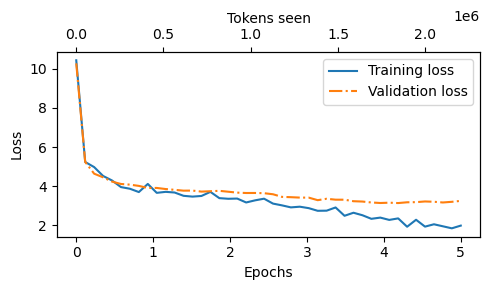

In [23]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses, file_name=None):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
         epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    
    if file_name:
        plt.savefig(file_name)  # Grafik dosyaya kaydedilir
        print(f"Grafik {file_name} olarak kaydedildi.")
    else:
        plt.show()  

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses, file_name="training_loss_plot.png")
